In [ ]:
!unzip processed_celeba_small.zip

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size,img_size,img_dir = 'processed_celeba_small/'):
    n_workers=0
    transform = transforms.Compose([transforms.Resize(size=img_size),
                                   transforms.CenterCrop((img_size,img_size)),
                                   transforms.ToTensor()])
    train_data = datasets.ImageFolder(root=img_dir,transform=transform)
    data_loader = torch.utils.data.DataLoader(train_data , batch_size=batch_size,shuffle=True,num_workers=n_workers)
    
    return data_loader

In [4]:
batch_size = 64
img_size=32
data_loader = get_dataloader(batch_size,img_size)

In [5]:
def img_show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    print(npimg.shape)

(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


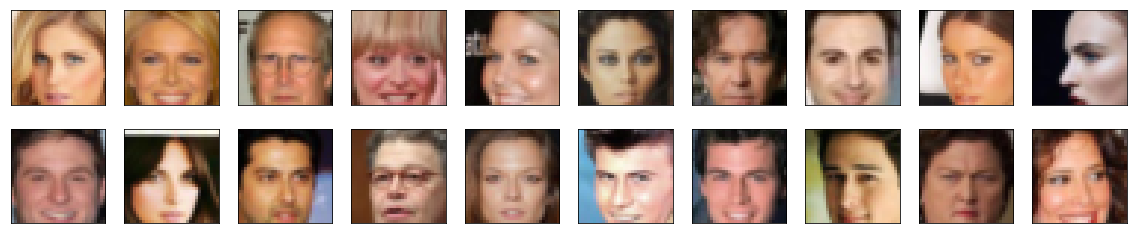

In [6]:
data_loader_iter = iter(data_loader)
images,_ = next(data_loader_iter)
fig = plt.figure(figsize=(20,4))


for i in range(20):
    ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    img_show(images[i])



In [7]:
def scale(x,feature_range = (-1,1)):
    # scale 到 -1 ~ 1 (因為tanh是-1,1)
    min_,max_ = feature_range
    x = x*(max_ - min_) + min_
    return x

In [8]:
scale(images[0])

tensor([[[ 0.8980,  0.8980,  0.7490,  ...,  0.5373,  0.5373,  0.5059],
         [ 0.9059,  0.8510,  0.5373,  ...,  0.5373,  0.5529,  0.5137],
         [ 0.9059,  0.7255,  0.3882,  ...,  0.5529,  0.5686,  0.5294],
         ...,
         [ 0.4431,  0.2392, -0.0196,  ...,  0.6000,  0.2157,  0.1529],
         [ 0.3569,  0.2235,  0.0039,  ...,  0.4745,  0.2235,  0.1373],
         [ 0.2784,  0.2863,  0.0353,  ...,  0.4275,  0.2471,  0.0980]],

        [[ 0.8275,  0.7725,  0.5216,  ...,  0.2549,  0.2706,  0.2471],
         [ 0.7961,  0.6941,  0.2784,  ...,  0.2471,  0.2784,  0.2471],
         [ 0.7569,  0.5216,  0.0824,  ...,  0.2549,  0.2784,  0.2549],
         ...,
         [ 0.0275, -0.2078, -0.4353,  ...,  0.0902, -0.2706, -0.2863],
         [-0.0275, -0.2235, -0.4275,  ..., -0.0431, -0.2549, -0.2941],
         [-0.0902, -0.1451, -0.3882,  ..., -0.0902, -0.2314, -0.3333]],

        [[ 0.7098,  0.6392,  0.2941,  ..., -0.0431, -0.0510, -0.1137],
         [ 0.6706,  0.5373,  0.0275,  ..., -0

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [30]:
def conv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
    
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

def deconv(in_channels,out_channels,kernel_size,stride=2,padding=1,batch_norm=True):
    layers= []
    
    deconv_layer = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
    layers.append(deconv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)
    
    
    

In [31]:
class Discriminator(nn.Module):
    def __init__(self,conv_dim):
        super(Discriminator,self).__init__()
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3,conv_dim,4,batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,4)
        self.conv3 = conv(conv_dim*2,conv_dim*4,4)
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        
        
    def forward(self,x):
        
        out = F.leaky_relu(self.conv1(x),0.2)
        out = F.leaky_relu(self.conv2(out),0.2)
        out = F.leaky_relu(self.conv3(out),0.2)
        
        out = out.view(-1,self.conv_dim*4*4*4)
        out = self.fc(out)
        return out
        
        

In [32]:
class Generator(nn.Module):
    def __init__(self,z_size,conv_dim):
        super(Generator,self).__init__()
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size,conv_dim*4*4*4)
        self.deconv1 = deconv(conv_dim*4,conv_dim*2,4)
        self.deconv2 = deconv(conv_dim*2,conv_dim,4)
        self.deconv3 = deconv(conv_dim,3,4,batch_norm=False)
        
    def forward(self,x):
        
        out = self.fc(x)
        out = out.view(-1,self.conv_dim*4,4,4)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.tanh(self.deconv3(out))
        
        return out    
    

In [33]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d')!=-1 or classname.find('Linear')!=-1:
        m.weight.data.normal_(0, 0.02)

In [34]:
d = Discriminator(32)
d.apply(weight_init)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [35]:
z_size = 100
g_conv_dim = 64

g = Generator(z_size,g_conv_dim)
g.apply(weight_init)

Generator(
  (fc): Linear(in_features=100, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv3): Sequential(
    (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

In [36]:
train_on_gpu = torch.cuda.is_available()
    

In [37]:
def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss
    
def real_loss(D_out,smooth=False):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    
    if smooth:
        labels = labels*0.9
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss
    
    

In [38]:
a=torch.from_numpy(np.array([[1,2,3]]))
a.size(1)

3

In [46]:
import torch.optim as optim
import pickle as pkl
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(d.parameters(),lr,[beta1,beta2])
g_optimizer = optim.Adam(g.parameters(),lr,[beta1,beta2])

In [40]:
def train(D,G,n_epochs,print_every=10):
    
    
    losses = []
    sample_images=[]
    
    if train_on_gpu:
        D = D.cuda()
        G = G.cuda()
        
    sample_size=16
    
    fixed_z = np.random.uniform(-1,1,size=(sample_size,z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    for epoch in range(n_epochs):
        
        for batch_i,(images,_) in enumerate(data_loader):
            
#             print(images.size())
            
            
            #### discriminator
            
            batch_size = images.size(0)
            real_images = scale(images)
            
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)
            D_real_loss = real_loss(D_real)
            
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
                
            D_fake = D(G(z))
            D_fake_loss = fake_loss(D_fake)
            
            
            D_loss = D_real_loss + D_fake_loss
            D_loss.backward()
            d_optimizer.step()
            
            ##### generator
            
            
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1,1,size=(batch_size,z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            
            G_fake = D(G(z))
            G_loss = real_loss(G_fake)
            
            G_loss.backward()
            g_optimizer.step()
            
            
            
            if batch_i % batch_size==0:
                losses.append([G_loss.item(),D_loss.item()])
                print('Epcoch {:5d}/{:5d} | dloss : {:6.4f} | gloss:{:6.4f}'.format(epoch+1,n_epochs,D_loss.item(),G_loss.item()))
            
        
        G.eval()
        samples_z = G(fixed_z)
        sample_images.append(samples_z)
        
        G.train()
        
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(sample_images, f)
    
    # finally return losses
    return losses


In [47]:
n_epochs = 10

losses = train(d, g, n_epochs=n_epochs)

Epcoch     1/    1 | dloss : 1.4046 | gloss:0.9978
Epcoch     1/    1 | dloss : 1.2918 | gloss:0.8952
Epcoch     1/    1 | dloss : 1.3279 | gloss:0.7040
Epcoch     1/    1 | dloss : 1.2331 | gloss:0.6801
Epcoch     1/    1 | dloss : 1.2481 | gloss:0.6484
Epcoch     1/    1 | dloss : 1.2633 | gloss:0.8834
Epcoch     1/    1 | dloss : 1.2659 | gloss:0.8717
Epcoch     1/    1 | dloss : 1.3482 | gloss:0.8344
Epcoch     1/    1 | dloss : 1.4505 | gloss:0.8182
Epcoch     1/    1 | dloss : 1.3102 | gloss:0.8800
Epcoch     1/    1 | dloss : 1.3002 | gloss:0.8545
Epcoch     1/    1 | dloss : 1.3813 | gloss:0.9516
Epcoch     1/    1 | dloss : 1.3242 | gloss:0.8316
Epcoch     1/    1 | dloss : 1.2244 | gloss:0.8773
Epcoch     1/    1 | dloss : 1.4885 | gloss:0.8766
Epcoch     1/    1 | dloss : 1.2839 | gloss:0.8803
Epcoch     1/    1 | dloss : 1.1741 | gloss:1.1692
Epcoch     1/    1 | dloss : 1.5983 | gloss:0.7968
Epcoch     1/    1 | dloss : 1.2988 | gloss:0.8373
Epcoch     1/    1 | dloss : 1.

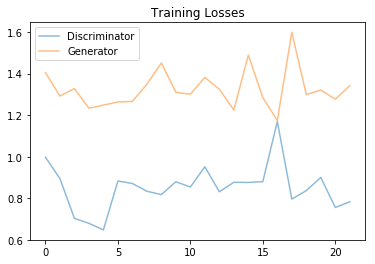

In [48]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [55]:
def view_result_image(epoch,samples):
    fig = plt.figure(figsize=(16,4))
    images = samples[epoch]
    for i in range(len(images)):
        ax = fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
        img = images[i].detach().cpu().numpy()
        img = np.transpose(img,(1,2,0))
        img = ((img+1)*255/2).astype(np.uint8)
        ax.imshow(img)

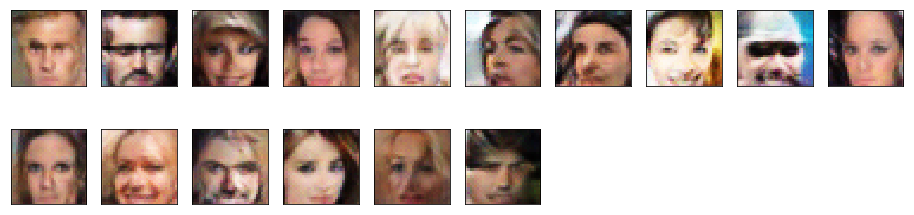

In [56]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
    
view_result_image(-1,samples)